### Import libraries

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import levene
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### Data preparation

In [7]:
file_path = "../Data/Final data/df_weekly.csv"
air_pollution = pd.read_csv(file_path)
air_pollution.head()

,time_stamp,humidity,temperature,pressure,pm2.5_alt
0,2021-06-13T00:00:00Z,22.356,89.166,862.016,11.9
1,2021-06-20T00:00:00Z,18.540,89.253,862.833,6.7
2,2021-10-03T00:00:00Z,44.773,58.555,904.565,17.7
3,2021-10-10T00:00:00Z,38.740,65.358,900.290,24.5
4,2021-10-17T00:00:00Z,36.401,60.033,901.388,18.4


### Correlation with temperature and humidity

In [8]:
df = air_pollution[['pm2.5_alt', 'temperature', 'humidity']]
correlations = df.corr(method='pearson')
print(correlations)

             pm2.5_alt  temperature  humidity
pm2.5_alt     1.000000    -0.730974  0.654476
temperature  -0.730974     1.000000 -0.722184
humidity      0.654476    -0.722184  1.000000


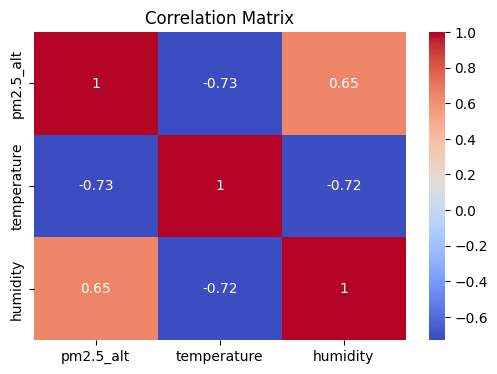

In [9]:
plt.figure(figsize=(6,4))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Autocorrelation

In [10]:
df_time_series = air_pollution[['time_stamp', 'pm2.5_alt', 'temperature', 'humidity']]
df_time_series['time_stamp'] = pd.to_datetime(df_time_series['time_stamp'])
df_time_series.set_index('time_stamp', inplace=True)
df_time_series = df_time_series.sort_index() 
df_time_series.head()

,pm2.5_alt,temperature,humidity
time_stamp,,,
2021-06-13 00:00:00+00:00,11.9,89.166,22.356
2021-06-20 00:00:00+00:00,6.7,89.253,18.540
2021-10-03 00:00:00+00:00,17.7,58.555,44.773
2021-10-10 00:00:00+00:00,24.5,65.358,38.740
2021-10-17 00:00:00+00:00,18.4,60.033,36.401


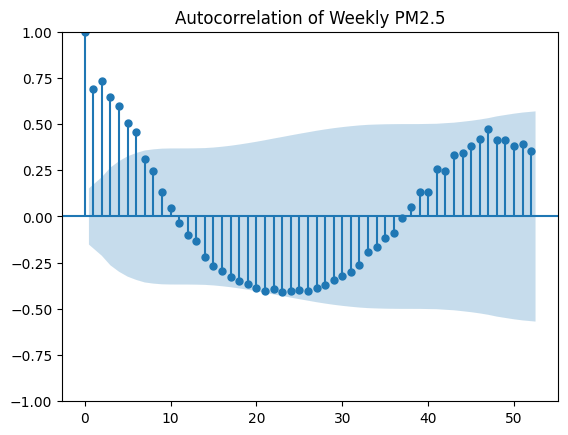

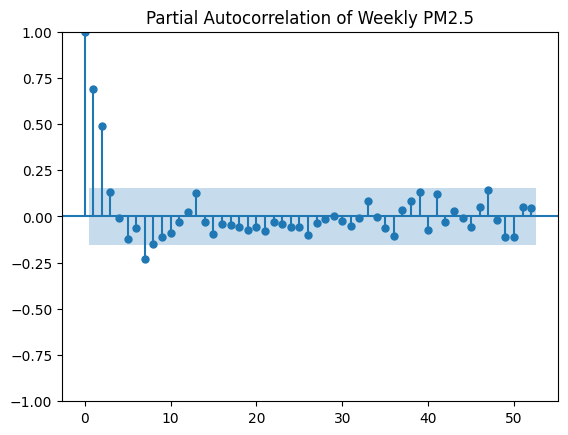

In [11]:
plot_acf(df_time_series['pm2.5_alt'].dropna(), lags=52)
plt.title('Autocorrelation of Weekly PM2.5')
plt.show()

plot_pacf(df_time_series['pm2.5_alt'].dropna(), lags=52)
plt.title('Partial Autocorrelation of Weekly PM2.5')
plt.show()


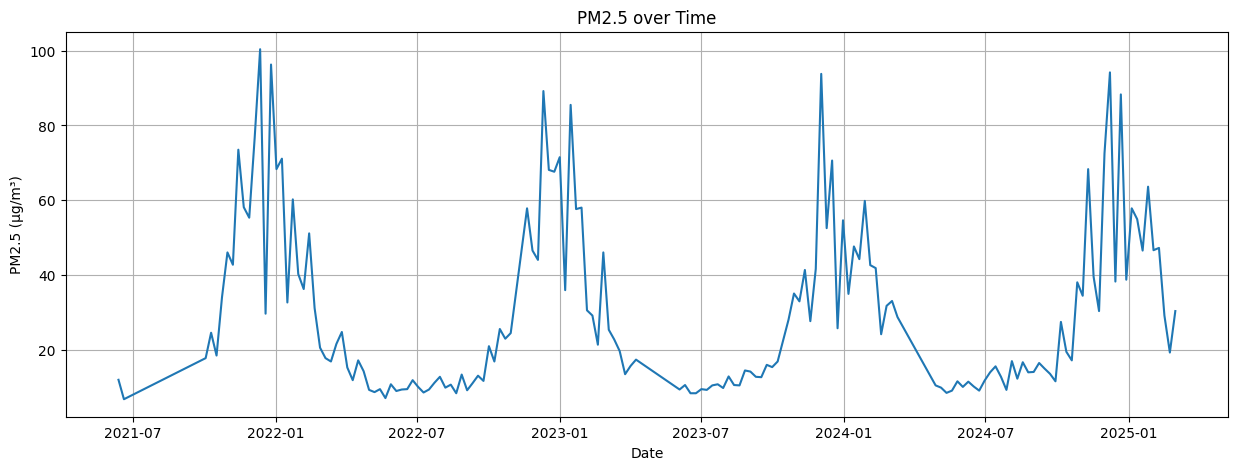

In [12]:
plt.figure(figsize=(15,5))
plt.plot(df_time_series['pm2.5_alt'], label='PM2.5')
plt.title('PM2.5 over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()

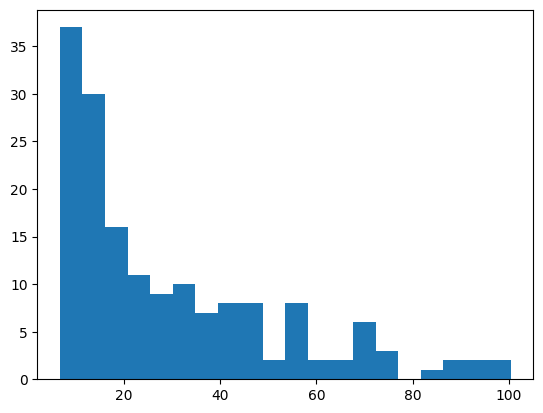

In [13]:
plt.hist(air_pollution['pm2.5_alt'], bins=20)
plt.show()

### Time series decomposition

In [14]:
midpoint = len(df_time_series) // 2
early = df_time_series['pm2.5_alt'].iloc[:midpoint]
late = df_time_series['pm2.5_alt'].iloc[midpoint:]

stat, p_value = levene(early, late)
print(f"Levene test p-value: {p_value}")

Levene test p-value: 0.49626806315366745


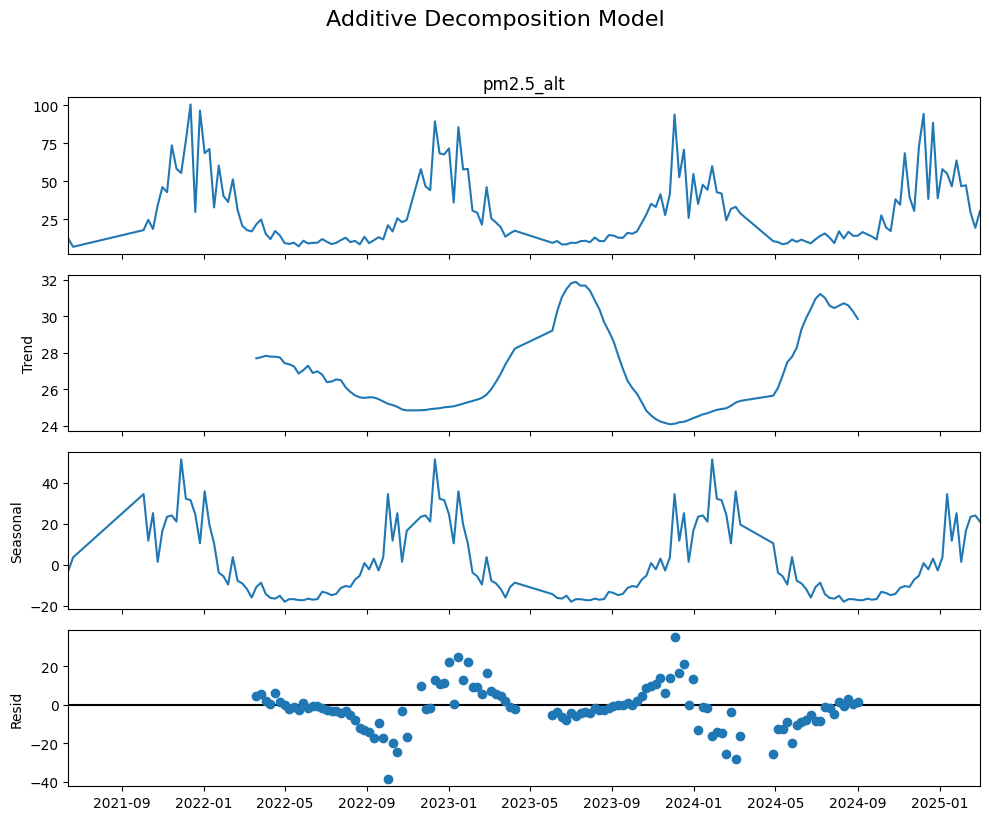

In [15]:
additive_decomposition = seasonal_decompose(df_time_series['pm2.5_alt'], model='additive', period=52)

fig = additive_decomposition.plot()
fig.set_size_inches(10, 8)  
fig.suptitle('Additive Decomposition Model', fontsize=16, y=1.02)  
plt.tight_layout()  
plt.show()


### Working with residuals

In [16]:
resid = additive_decomposition.resid.dropna()
ljung_result = acorr_ljungbox(resid, lags=[10], return_df=True)
print(ljung_result)

       lb_stat     lb_pvalue
10  248.143144  1.333498e-47


In [17]:
model = pm.auto_arima(df_time_series['pm2.5_alt'], 
                      seasonal=True, 
                      m=52,                      
                      trace=True,                
                      error_action='ignore',     
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=1345.318, Time=5.20 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1509.921, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1405.864, Time=1.28 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1449.366, Time=1.82 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1674.114, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=1343.482, Time=4.33 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=1343.295, Time=0.13 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=1343.360, Time=5.16 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=1357.441, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=1360.389, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[52] intercept   : AIC=1331.114, Time=0.18 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=1336.432, Time=5.87 sec
 ARIMA(3,0,2)(0,0,1)[52] intercept   : AIC=1330.111, Time=6.14 sec
 ARIMA(3,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=7.05 sec
 ARIMA(3,0,2)(0,0,2)[52]

In [18]:
df_time_series['weekly_diff'] = df_time_series['pm2.5_alt'].diff()

In [19]:
mean_change = df_time_series['weekly_diff'].mean()
std_change = df_time_series['weekly_diff'].std()
max_change = df_time_series['weekly_diff'].abs().max()

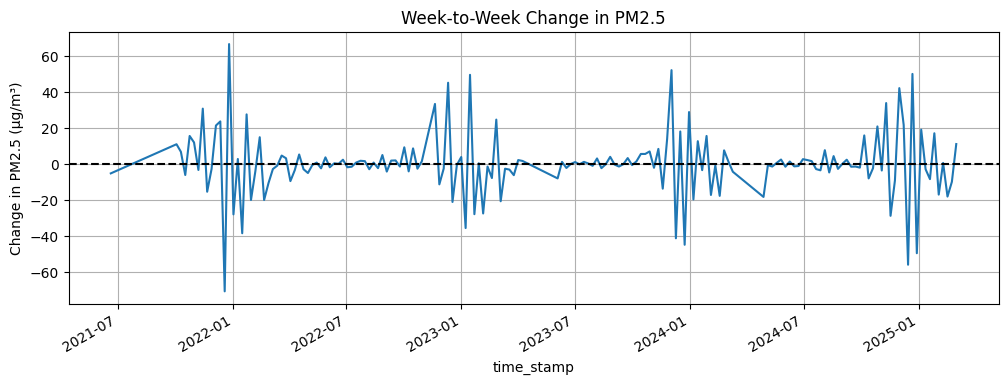

In [20]:
df_time_series['weekly_diff'].plot(figsize=(12,4), title='Week-to-Week Change in PM2.5')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Change in PM2.5 (µg/m³)')
plt.grid(True)
plt.show()


# SARIMA model

In [21]:
n_periods = 70
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

last_date = df_time_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=n_periods, freq='W')

sarima_forecast = pd.DataFrame({
    'Date': future_dates,
    'SARIMA': forecast,
    'Lower_CI': conf_int[:, 0],
    'Upper_CI': conf_int[:, 1]
}).set_index('Date')


In [22]:
y = df_time_series['pm2.5_alt']
n_test = 80
y_train = y[:-n_test]
y_test = y[-n_test:]

forecast, conf_int = model.predict(n_periods=n_test, return_conf_int=True)

mae_sarima = mean_absolute_error(y_test, forecast)
rmse_sarima = sqrt(mean_squared_error(y_test, forecast))

print(f"Mean Absolute Error (MAE) for SARIMA model: {mae_sarima:.2f}")
print(f"Root Mean Squared Error (RMSE) for SARIMA model: {rmse_sarima:.2f}")


Mean Absolute Error (MAE) for SARIMA model: 17.21
Root Mean Squared Error (RMSE) for SARIMA model: 21.86


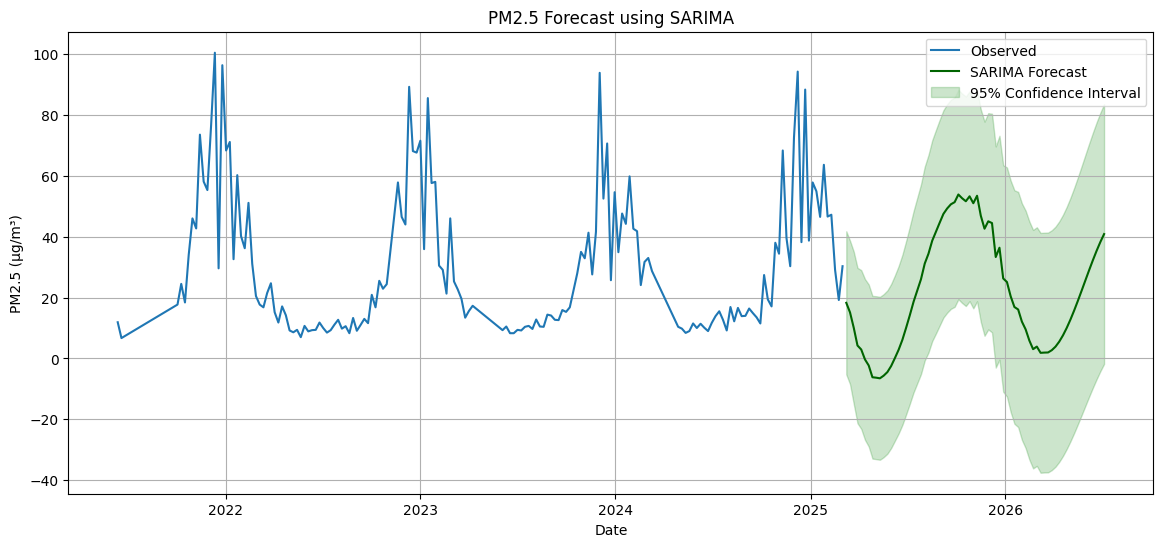

In [23]:
plt.figure(figsize=(14, 6))
plt.plot(df_time_series['pm2.5_alt'], label='Observed')
plt.plot(sarima_forecast['SARIMA'], label='SARIMA Forecast', color='darkgreen')
plt.fill_between(sarima_forecast.index, sarima_forecast['Lower_CI'], sarima_forecast['Upper_CI'],
                 color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('PM2.5 Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

# Exponential Smoothing

In [24]:
ets_model = ExponentialSmoothing(
    df_time_series['pm2.5_alt'],
    trend='add',
    seasonal='add',
    seasonal_periods=52
).fit()

n_periods = 70
ets_forecast = ets_model.forecast(n_periods)

last_date = df_time_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=n_periods, freq='W')

residuals = ets_model.resid
residual_std = np.std(residuals)

z_score = norm.ppf(0.975)  

lower_ci = ets_forecast - z_score * residual_std
upper_ci = ets_forecast + z_score * residual_std

ets_pred = pd.DataFrame({
    'Date': future_dates,
    'ETS': ets_forecast.values,
    'Lower_CI': lower_ci.values,
    'Upper_CI': upper_ci.values
}).set_index('Date')

ets_forecast = ets_model.forecast(n_test)

mae_ets = mean_absolute_error(y_test, ets_forecast)
rmse_ets = sqrt(mean_squared_error(y_test, ets_forecast))

print(f"Mean Absolute Error (MAE) for ETS model: {mae_ets:.2f}")
print(f"Root Mean Squared Error (RMSE) for ETS model: {rmse_ets:.2f}")


Mean Absolute Error (MAE) for ETS model: 31.78
Root Mean Squared Error (RMSE) for ETS model: 38.55


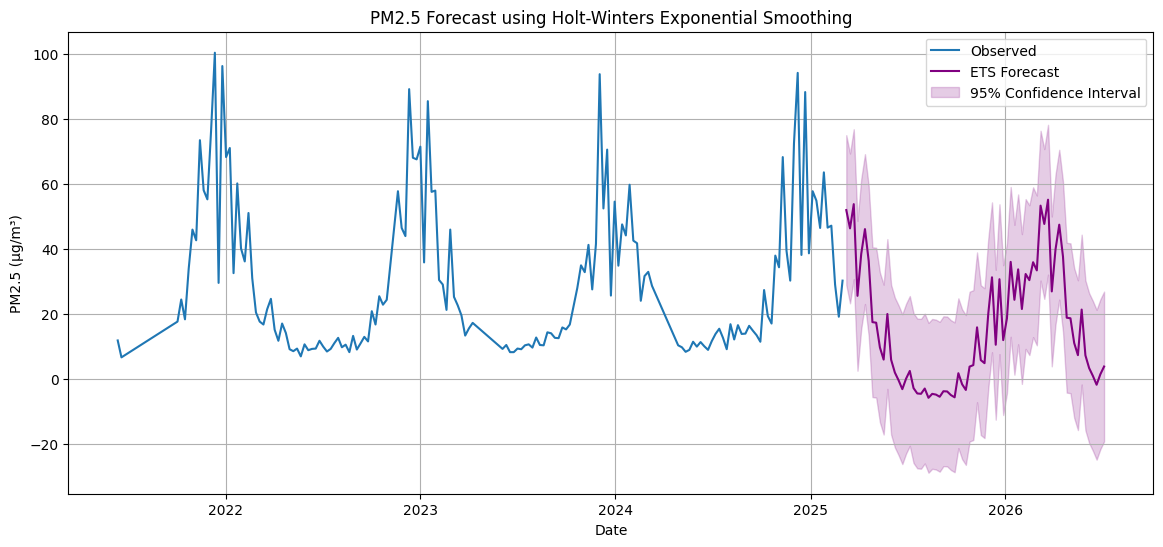

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(df_time_series['pm2.5_alt'], label='Observed')
plt.plot(ets_pred['ETS'], label='ETS Forecast', color='purple')

plt.fill_between(
    ets_pred.index,
    ets_pred['Lower_CI'],
    ets_pred['Upper_CI'],
    color='purple',
    alpha=0.2,
    label='95% Confidence Interval'
)

plt.title('PM2.5 Forecast using Holt-Winters Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()


# XGBoost

In [26]:
df_time_series['pm2.5_lag1'] = df_time_series['pm2.5_alt'].shift(1)
df_time_series['pm2.5_lag2'] = df_time_series['pm2.5_alt'].shift(2)

df_time_series['month'] = df_time_series.index.month
df_time_series['week'] = df_time_series.index.isocalendar().week
df_time_series['dayofweek'] = df_time_series.index.dayofweek

df_time_series = df_time_series.dropna()

X = df_time_series[['pm2.5_lag1', 'pm2.5_lag2', 'month', 'week', 'dayofweek']]
y = df_time_series['pm2.5_alt']

xgb = XGBRegressor()
xgb.fit(X, y)

df_time_series['XGB_Pred'] = xgb.predict(X)

forecast_weeks = 70
last_lag1 = df_time_series['pm2.5_alt'].iloc[-1]
last_lag2 = df_time_series['pm2.5_alt'].iloc[-2]

future_dates = pd.date_range(start=df_time_series.index[-1] + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='W')
xgb_forecast = []

for date in future_dates:
    month = date.month
    week = date.isocalendar().week
    dayofweek = date.dayofweek

    features = np.array([[last_lag1, last_lag2, month, week, dayofweek]])
    pred = xgb.predict(features)[0]
    xgb_forecast.append(pred)

    last_lag2 = last_lag1
    last_lag1 = pred


xgb_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'XGB_70W_Forecast': xgb_forecast
}).set_index('Date')

X_train, X_test = X[:-n_test], X[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

y_pred = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE) for XGBoost model: {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE) for XGBoost model: {rmse_xgb:.2f}")

residuals = y_test - y_pred
residual_std = np.std(residuals, ddof=1)
residual_std = max(residual_std, 1.0) 

z_score = norm.ppf(0.975)  # 95% CI

lower_ci = np.array(xgb_forecast) - z_score * residual_std
upper_ci = np.array(xgb_forecast) + z_score * residual_std

xgb_forecast_df['Lower_CI'] = lower_ci
xgb_forecast_df['Upper_CI'] = upper_ci


Mean Absolute Error (MAE) for XGBoost model: 0.02
Root Mean Squared Error (RMSE) for XGBoost model: 0.03


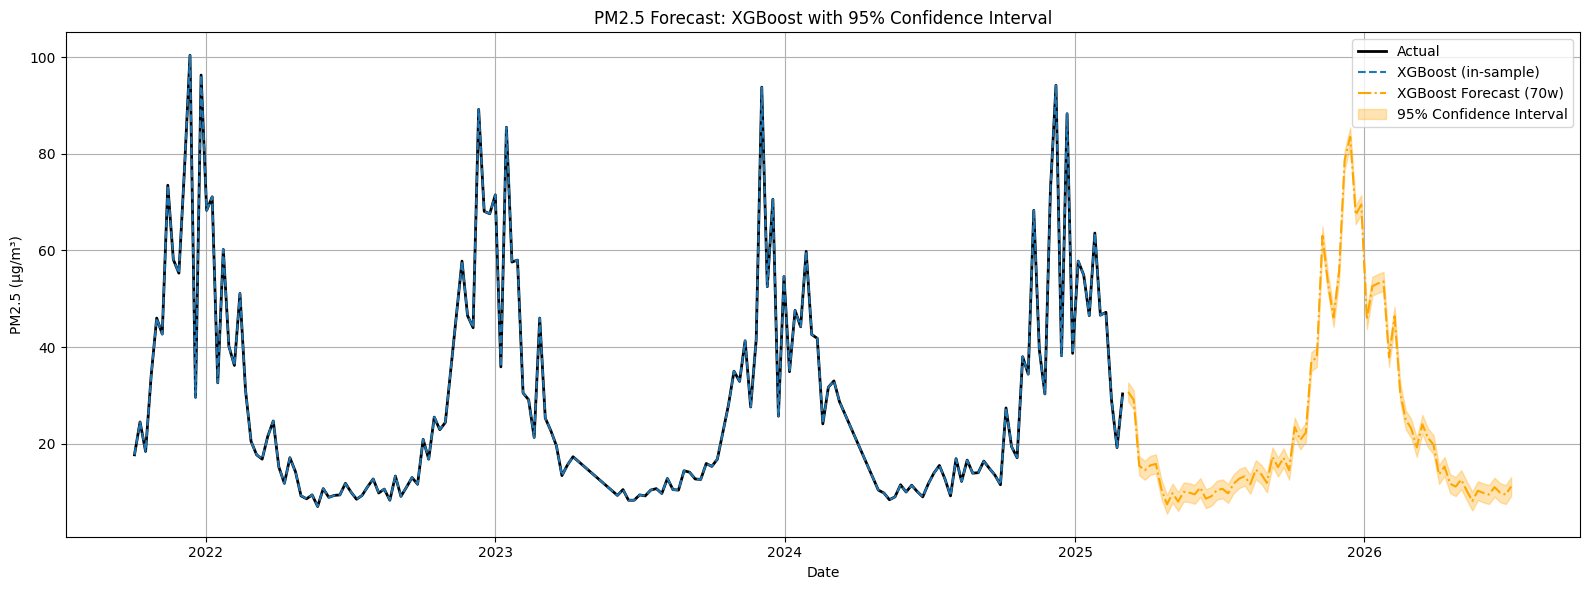

In [27]:
plt.figure(figsize=(16, 6))

plt.plot(df_time_series.index, df_time_series['pm2.5_alt'], label='Actual', color='black', linewidth=2)
plt.plot(df_time_series.index, df_time_series['XGB_Pred'], label='XGBoost (in-sample)', linestyle='--')
plt.plot(xgb_forecast_df.index, xgb_forecast_df['XGB_70W_Forecast'], label='XGBoost Forecast (70w)', linestyle='-.', color='orange')

# Shaded confidence interval
plt.fill_between(
    xgb_forecast_df.index,
    xgb_forecast_df['Lower_CI'],
    xgb_forecast_df['Upper_CI'],
    color='orange',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('PM2.5 Forecast: XGBoost with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
residuals = df_time_series['pm2.5_alt'] - df_time_series['XGB_Pred']
residual_std = np.std(residuals)

z_score = norm.ppf(0.975)  
xgb_forecast = np.array(xgb_forecast)
lower_bound = xgb_forecast - z_score * residual_std
upper_bound = xgb_forecast + z_score * residual_std

xgboost_pred = pd.DataFrame({
    'Date': future_dates,
    'XHBoost': xgb_forecast,
    'Lower_Bound': lower_bound,
    'Upper_Bound': upper_bound
})

xgboost_pred = xgboost_pred.set_index('Date')
print(xgboost_pred.head())


                             XHBoost  Lower_Bound  Upper_Bound
Date                                                          
2025-03-09 00:00:00+00:00  30.721062    30.665535    30.776588
2025-03-16 00:00:00+00:00  29.061647    29.006121    29.117174
2025-03-23 00:00:00+00:00  15.425252    15.369725    15.480779
2025-03-30 00:00:00+00:00  14.508918    14.453391    14.564445
2025-04-06 00:00:00+00:00  15.527133    15.471606    15.582660


# SARIMAX including exogenous inputs of temperature and humidity

In [29]:
exog_vars = df_time_series[['temperature', 'humidity']]  
exog_vars = exog_vars.loc[y.index]  

scaler = StandardScaler()
exog_scaled = pd.DataFrame(
    scaler.fit_transform(exog_vars),
    columns=exog_vars.columns,
    index=exog_vars.index
)

model_sarimax = SARIMAX(
    endog=y,
    exog=exog_scaled,
    order=(3, 0, 2),
    seasonal_order=(0, 0, 1, 52),
    enforce_stationarity=True,
    enforce_invertibility=True
)
results_sarimax = model_sarimax.fit(disp=False, maxiter=50)

forecast_weeks = 70
last_date = y.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='W')

last_exog_row = exog_scaled.iloc[-1]
future_exog = pd.DataFrame(
    [last_exog_row.values] * forecast_weeks,
    columns=exog_scaled.columns,
    index=future_dates
)

forecast_sarimax = results_sarimax.get_forecast(steps=forecast_weeks, exog=future_exog)
sarimax_forecast_values = forecast_sarimax.predicted_mean
conf_int = forecast_sarimax.conf_int()

sarimax_pred = pd.DataFrame({
    'Date': future_dates,
    'SARIMAX_exogeneous': sarimax_forecast_values.values,
    'Lower_Bound': conf_int.iloc[:, 0].values,
    'Upper_Bound': conf_int.iloc[:, 1].values
}).set_index('Date')

y_train, y_test = y[:-n_test], y[-n_test:]
exog_train, exog_test = exog_scaled.loc[y_train.index], exog_scaled.loc[y_test.index]

forecast_sarimax = results_sarimax.get_forecast(steps=n_test, exog=exog_test)
y_pred = forecast_sarimax.predicted_mean

mae_sarimax = mean_absolute_error(y_test, y_pred)
rmse_sarimax = sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE) for SARIMAX model: {mae_sarimax:.2f}")
print(f"Root Mean Squared Error (RMSE) for SARIMAX model: {rmse_sarimax:.2f}")


Mean Absolute Error (MAE) for SARIMAX model: 26.74
Root Mean Squared Error (RMSE) for SARIMAX model: 34.67


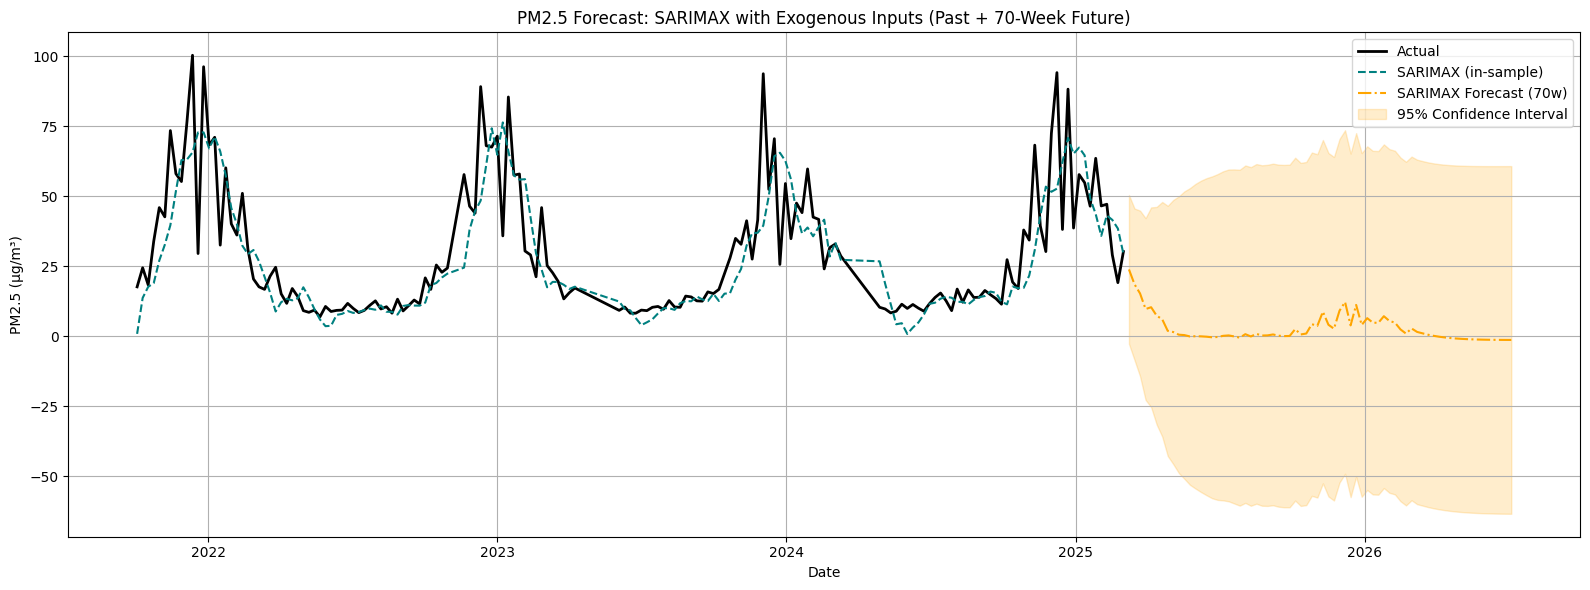

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(y.index, y, label='Actual', color='black', linewidth=2)
plt.plot(y.index, results_sarimax.fittedvalues, label='SARIMAX (in-sample)', linestyle='--', color='teal')
plt.plot(sarimax_pred.index, sarimax_pred['SARIMAX_exogeneous'], label='SARIMAX Forecast (70w)', linestyle='-.', color='orange')
plt.fill_between(sarimax_pred.index, sarimax_pred['Lower_Bound'], sarimax_pred['Upper_Bound'],
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title('PM2.5 Forecast: SARIMAX with Exogenous Inputs (Past + 70-Week Future)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Random forest

In [31]:
df_rf = df_time_series.copy()
df_rf['pm2.5_lag1'] = df_rf['pm2.5_alt'].shift(1)
df_rf['pm2.5_lag2'] = df_rf['pm2.5_alt'].shift(2)

df_rf['month'] = df_rf.index.month
df_rf['week'] = df_rf.index.isocalendar().week
df_rf['dayofweek'] = df_rf.index.dayofweek

df_rf = df_rf.dropna()

X_rf = df_rf[['pm2.5_lag1', 'pm2.5_lag2', 'month', 'week', 'dayofweek']]
y_rf = df_rf['pm2.5_alt']

rf = RandomForestRegressor()
rf.fit(X_rf, y_rf)

df_rf['RF_Pred'] = rf.predict(X_rf)

forecast_weeks = 70
last_lag1_rf = df_rf['pm2.5_alt'].iloc[-1]
last_lag2_rf = df_rf['pm2.5_alt'].iloc[-2]

future_dates = pd.date_range(start=df_rf.index[-1] + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='W')
rf_forecast = []

for date in future_dates:
    month = date.month
    week = date.isocalendar().week
    dayofweek = date.dayofweek

    features = np.array([[last_lag1_rf, last_lag2_rf, month, week, dayofweek]])
    pred = rf.predict(features)[0]
    rf_forecast.append(pred)

    last_lag2_rf = last_lag1_rf
    last_lag1_rf = pred

rf_forecast = np.array(rf_forecast)

residuals_rf = df_rf['pm2.5_alt'] - df_rf['RF_Pred']
residual_std_rf = np.std(residuals_rf)
z_score = norm.ppf(0.975)

lower_bound_rf = rf_forecast - z_score * residual_std_rf
upper_bound_rf = rf_forecast + z_score * residual_std_rf

random_forest_pred = pd.DataFrame({
    'Date': future_dates,
    'RF': rf_forecast,
    'Lower_Bound': lower_bound_rf,
    'Upper_Bound': upper_bound_rf
}).set_index('Date')

X_train_rf, X_test_rf = X_rf[:-n_test], X_rf[-n_test:]
y_train_rf, y_test_rf = y_rf[:-n_test], y_rf[-n_test:]
rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)

mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
rmse_rf = sqrt(mean_squared_error(y_test_rf, y_pred_rf))

print(f"Mean Absolute Error (MAE) for Random Forest: {mae_rf:.2f}")
print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf:.2f}")


Mean Absolute Error (MAE) for Random Forest: 7.97
Root Mean Squared Error (RMSE) for Random Forest: 12.53


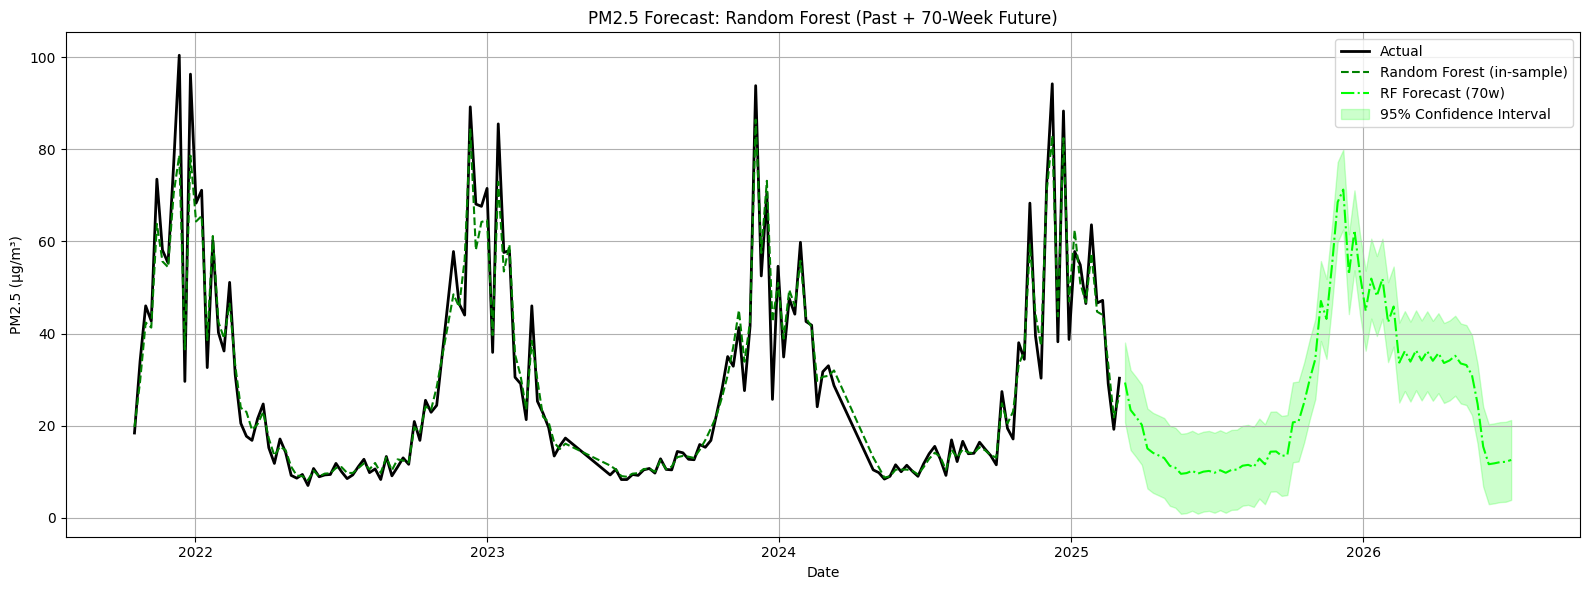

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(df_rf.index, df_rf['pm2.5_alt'], label='Actual', color='black', linewidth=2)
plt.plot(df_rf.index, df_rf['RF_Pred'], label='Random Forest (in-sample)', linestyle='--', color='green')
plt.plot(random_forest_pred.index, random_forest_pred['RF'], label='RF Forecast (70w)', linestyle='-.', color='lime')
plt.fill_between(random_forest_pred.index, random_forest_pred['Lower_Bound'], random_forest_pred['Upper_Bound'],
                 color='lime', alpha=0.2, label='95% Confidence Interval')
plt.title('PM2.5 Forecast: Random Forest (Past + 70-Week Future)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SVR

In [33]:
df_svr = df_time_series.copy()
df_svr['pm2.5_lag1'] = df_svr['pm2.5_alt'].shift(1)
df_svr['pm2.5_lag2'] = df_svr['pm2.5_alt'].shift(2)

df_svr['month'] = df_svr.index.month
df_svr['week'] = df_svr.index.isocalendar().week
df_svr['dayofweek'] = df_svr.index.dayofweek

df_svr = df_svr.dropna()

X_svr = df_svr[['pm2.5_lag1', 'pm2.5_lag2', 'pm2.5_alt', 'month', 'week', 'dayofweek']]
y_svr = df_svr['pm2.5_alt']

svr = SVR()
svr.fit(X_svr, y_svr)

df_svr['SVR_Pred'] = svr.predict(X_svr)

forecast_weeks = 70
last_lag1_svr = df_svr['pm2.5_alt'].iloc[-1]
last_lag2_svr = df_svr['pm2.5_alt'].iloc[-2]

future_dates = pd.date_range(start=df_svr.index[-1] + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='W')
svr_forecast = []

for date in future_dates:
    month = date.month
    week = date.isocalendar().week
    dayofweek = date.dayofweek

    features = np.array([[last_lag1_svr, last_lag2_svr, last_lag1_svr, month, week, dayofweek]])
    pred = svr.predict(features)[0]
    svr_forecast.append(pred)

    last_lag2_svr = last_lag1_svr
    last_lag1_svr = pred

residuals_svr = df_svr['pm2.5_alt'] - df_svr['SVR_Pred']
residual_std_svr = np.std(residuals_svr)
z_score = norm.ppf(0.975)

svr_forecast = np.array(svr_forecast)
lower_bound_svr = svr_forecast - z_score * residual_std_svr
upper_bound_svr = svr_forecast + z_score * residual_std_svr

svr_pred = pd.DataFrame({
    'Date': future_dates,
    'SVR': svr_forecast,
    'Lower_Bound': lower_bound_svr,
    'Upper_Bound': upper_bound_svr
}).set_index('Date')


X_train_svr, X_test_svr = X_svr[:-n_test], X_svr[-n_test:]
y_train_svr, y_test_svr = y_svr[:-n_test], y_svr[-n_test:]

svr.fit(X_train_svr, y_train_svr)

y_pred_svr = svr.predict(X_test_svr)

mae_svr = mean_absolute_error(y_test_svr, y_pred_svr)
rmse_svr = sqrt(mean_squared_error(y_test_svr, y_pred_svr))

print(f"Mean Absolute Error (MAE) for SVR: {mae_svr:.2f}")
print(f"Root Mean Squared Error (RMSE) for SVR: {rmse_svr:.2f}")


Mean Absolute Error (MAE) for SVR: 7.99
Root Mean Squared Error (RMSE) for SVR: 14.08


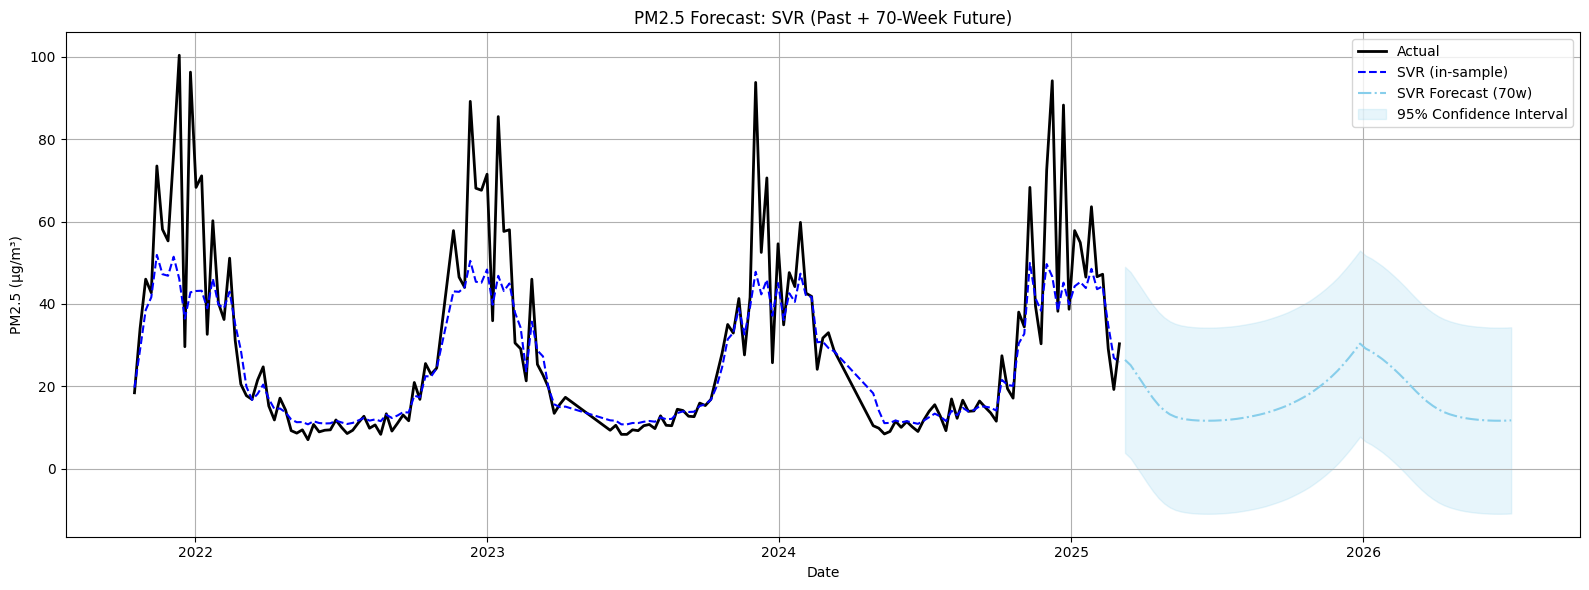

In [34]:
plt.figure(figsize=(16, 6))
plt.plot(df_svr.index, df_svr['pm2.5_alt'], label='Actual', color='black', linewidth=2)
plt.plot(df_svr.index, df_svr['SVR_Pred'], label='SVR (in-sample)', linestyle='--', color='blue')
plt.plot(svr_pred.index, svr_pred['SVR'], label='SVR Forecast (70w)', linestyle='-.', color='skyblue')
plt.fill_between(svr_pred.index, svr_pred['Lower_Bound'], svr_pred['Upper_Bound'],
                 color='skyblue', alpha=0.2, label='95% Confidence Interval')
plt.title('PM2.5 Forecast: SVR (Past + 70-Week Future)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
sarima_forecast.head()

,SARIMA,Lower_CI,Upper_CI
Date,,,
2025-03-09 00:00:00+00:00,18.269133,-5.238346,41.776612
2025-03-16 00:00:00+00:00,15.126061,-8.415972,38.668095
2025-03-23 00:00:00+00:00,10.072303,-14.923104,35.067709
2025-03-30 00:00:00+00:00,4.255227,-21.259876,29.770331
2025-04-06 00:00:00+00:00,2.946914,-23.115485,29.009314


In [36]:
ets_pred.head()

,ETS,Lower_CI,Upper_CI
Date,,,
2025-03-09 00:00:00+00:00,52.001545,28.959160,75.043930
2025-03-16 00:00:00+00:00,46.363798,23.321413,69.406183
2025-03-23 00:00:00+00:00,53.826269,30.783884,76.868654
2025-03-30 00:00:00+00:00,25.620934,2.578549,48.663319
2025-04-06 00:00:00+00:00,38.522716,15.480331,61.565101


In [37]:
xgboost_pred.head()

,XHBoost,Lower_Bound,Upper_Bound
Date,,,
2025-03-09 00:00:00+00:00,30.721062,30.665535,30.776588
2025-03-16 00:00:00+00:00,29.061647,29.006121,29.117174
2025-03-23 00:00:00+00:00,15.425252,15.369725,15.480779
2025-03-30 00:00:00+00:00,14.508918,14.453391,14.564445
2025-04-06 00:00:00+00:00,15.527133,15.471606,15.582660


In [38]:
sarimax_pred.head()

,SARIMAX_exogeneous,Lower_Bound,Upper_Bound
Date,,,
2025-03-09 00:00:00+00:00,23.917263,-2.669423,50.503948
2025-03-16 00:00:00+00:00,18.630035,-8.416434,45.676504
2025-03-23 00:00:00+00:00,15.348604,-14.216897,44.914105
2025-03-30 00:00:00+00:00,9.777160,-22.674821,42.229141
2025-04-06 00:00:00+00:00,10.420511,-25.227409,46.068431


In [39]:
random_forest_pred.head()

,RF,Lower_Bound,Upper_Bound
Date,,,
2025-03-09 00:00:00+00:00,29.356,20.678098,38.033902
2025-03-16 00:00:00+00:00,23.381,14.703098,32.058902
2025-03-23 00:00:00+00:00,21.844,13.166098,30.521902
2025-03-30 00:00:00+00:00,20.179,11.501098,28.856902
2025-04-06 00:00:00+00:00,15.040,6.362098,23.717902


In [40]:
svr_pred.head()

,SVR,Lower_Bound,Upper_Bound
Date,,,
2025-03-09 00:00:00+00:00,26.388742,3.780011,48.997473
2025-03-16 00:00:00+00:00,25.112005,2.503274,47.720736
2025-03-23 00:00:00+00:00,23.085168,0.476437,45.693899
2025-03-30 00:00:00+00:00,21.088972,-1.519759,43.697703
2025-04-06 00:00:00+00:00,19.022933,-3.585798,41.631664


In [44]:
combined_df = pd.DataFrame({
    "Date": sarima_forecast.index,
    "SARIMA": sarima_forecast["SARIMA"].values,
    "ETS": ets_pred["ETS"].values,
    "XGBoost": xgboost_pred["XHBoost"].values,
    "SARIMAX": sarimax_pred["SARIMAX_exogeneous"].values,
    "Random Forest": random_forest_pred["RF"].values,
    "SVR": svr_pred["SVR"].values
})

combined_df.set_index("Date", inplace=True)

print(combined_df.head())

                              SARIMA        ETS    XGBoost    SARIMAX  \
Date                                                                    
2025-03-09 00:00:00+00:00  18.269133  52.001545  30.721062  23.917263   
2025-03-16 00:00:00+00:00  15.126061  46.363798  29.061647  18.630035   
2025-03-23 00:00:00+00:00  10.072303  53.826269  15.425252  15.348604   
2025-03-30 00:00:00+00:00   4.255227  25.620934  14.508918   9.777160   
2025-04-06 00:00:00+00:00   2.946914  38.522716  15.527133  10.420511   

                           Random Forest        SVR  
Date                                                 
2025-03-09 00:00:00+00:00         29.356  26.388742  
2025-03-16 00:00:00+00:00         23.381  25.112005  
2025-03-23 00:00:00+00:00         21.844  23.085168  
2025-03-30 00:00:00+00:00         20.179  21.088972  
2025-04-06 00:00:00+00:00         15.040  19.022933  


In [45]:
df_time_series['Naive_Forecast'] = df_time_series['pm2.5_alt'].shift(1)
df_time_series = df_time_series.dropna()

X_naive = df_time_series[['Naive_Forecast']]  
y_naive = df_time_series['pm2.5_alt']

mse_naive = mean_squared_error(y_naive, X_naive)
rmse_naive = np.sqrt(mse_naive)
print(f"Naive Forecast MSE: {mse_naive}")
print(f"Naive Forecast RMSE: {rmse_naive}")


Naive Forecast MSE: 321.25802469135795
Naive Forecast RMSE: 17.92367218767845


In [ ]:
results_df = pd.DataFrame({
    'Model': ['Naive', 'SARIMA', 'ETS', 'SARIMAX', 'XGBoost', 'Random Forest', 'SVR'],
    'MSE': [mse_naive, mae_sarima, mae_ets, mae_sarimax, mae_xgb, mae_rf, mae_svr],
    'RMSE': [rmse_naive, rmse_sarima, rmse_ets, rmse_sarimax, rmse_xgb, rmse_rf, rmse_svr]
})

print(results_df.to_string(index=False))
results_df.to_csv("forecast_comparison_weekly.csv")

        Model        MSE      RMSE
        Naive 321.258025 17.923672
       SARIMA  17.210223 21.859985
          ETS  31.778624 38.549233
      SARIMAX  26.739817 34.673889
      XGBoost   0.021272  0.029172
Random Forest   7.971500 12.525622
          SVR   7.988798 14.077400


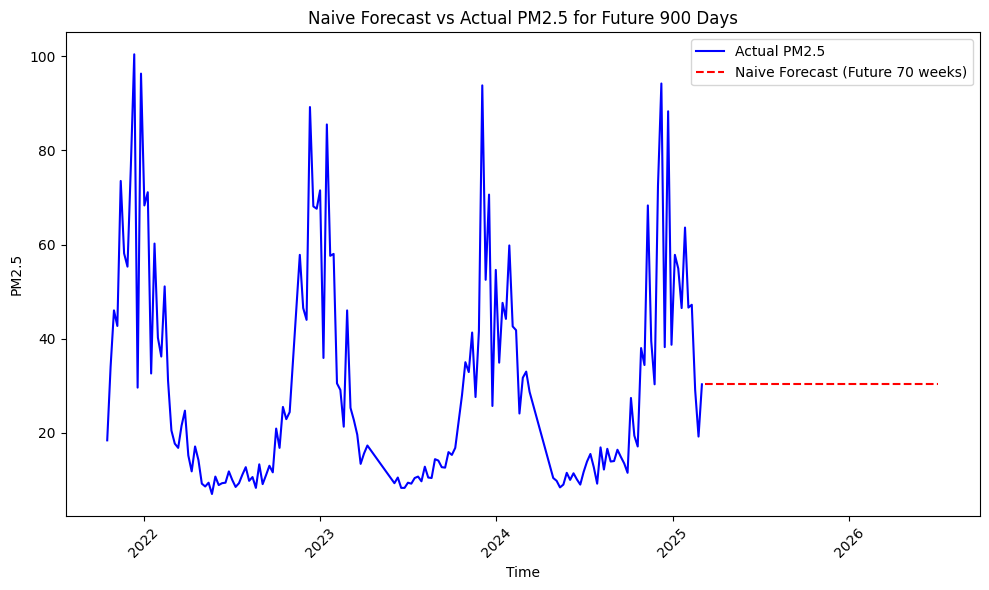

In [47]:
last_known_value = df_time_series['pm2.5_alt'].iloc[-1]
future_index = pd.date_range(df_time_series.index[-1] + pd.Timedelta(days=1), periods=70, freq='W')

future_forecast_values = [last_known_value] * 70

df_future_forecast = pd.DataFrame(future_forecast_values, index=future_index, columns=['Naive_Forecast'])
plt.figure(figsize=(10, 6))
plt.plot(df_time_series.index, df_time_series['pm2.5_alt'], label='Actual PM2.5', color='blue')
plt.plot(df_future_forecast.index, df_future_forecast['Naive_Forecast'], label='Naive Forecast (Future 70 weeks)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title('Naive Forecast vs Actual PM2.5 for Future 900 Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
